# BioImageIO Crowd Sourcing Demo

This notebook runs a BioEngine server equipped with Kaibu, an interactive image annotation tool in the browser. It allows the annotation of images in a collaborative manner.

As a demo, we will collect image annotations from the participants and train a CellPose model using dose.
Most of the notebook is based on the original [CellPose notebook](https://github.com/mouseland/cellpose)

# 0. Setup

We will first install all the dependencies required for Kaibu, ImJoy and cellpose 2.0, check the GPU is working, and mount google drive to get your models and images.

### 0.1 Installation
Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

Please, restart the session afetr installing the requirements.

In [ ]:
## Install required dependencies
!git clone https://github.com/bioimage-io/bioimageio-colab.git
!pip install -r "/content/bioimageio-colab/requirements-colab.txt"

### 0.2 Mount google drive

Please mount your google drive and find your working folder with (if available) the model that you trained. If you want to train a model, create a folder in google drive with the images and the labels, either `_seg.npy` files from the cellpose gui, or `_masks.tif` files.

In [2]:
###Run this cell to connect your Google Drive to Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. Launch the BioEngine for Collaborative annotations

## 1.1 Download the example dataset (optional)

In [ ]:
!wget "https://github.com/bioimage-io/bioimageio-colab/releases/download/v0.1/hpa-dataset-v2-98-rgb.zip"
!mkdir "data"
!unzip hpa-dataset-v2-98-rgb.zip -d data/

## 1.2 Setup corresponding paths

In [2]:
import os
path2data = "/content/data"
outpath = "/content/kaibu_annotations"
os.makedirs(outpath, exist_ok=True)

## 1.3 Launch the BioEngine server with Kaibu
This cell will output a shareable link that you can use to open the annotation tool in the browser. 

In [4]:
import os
from imjoy_rpc.hypha import connect_to_server
import numpy as np
# Prepare paths for output
from tifffile import imread, imwrite
from kaibu_utils import fetch_image, features_to_mask
import urllib


#!wget "https://github.com/bioimage-io/bioimageio-colab/releases/download/v0.1/hpa-dataset-v2-98-rgb.zip"
#!mkdir "data"
#!unzip hpa-dataset-v2-98-rgb.zip -d data/

training_images = []

path2label = os.path.join(outpath, "labels")
os.makedirs(path2label, exist_ok=True)

path2source = os.path.join(outpath, "source")
os.makedirs(path2source, exist_ok=True)
# Connect to the server link
server_url = "https://ai.imjoy.io"
server = await connect_to_server({"server_url": server_url})

# When multiple people open the link above, they can join a common workspace as an ImJoy client
def add_image(image, label):
    training_images.append((image, label))
    print(f"{len(training_images)} available already.")
    return

def get_random_image():
    filenames = [f for f in os.listdir(path2data) if f.endswith(".tif")]
    n = np.random.randint(len(filenames)-1)
    image = imread(os.path.join(path2data, filenames[n]))
    if len(image.shape)==3 and image.shape[0]==3:
        image = np.transpose(image, [1,2,0])
    #print(image.shape)
    new_filename = f"{len(os.listdir(path2source)) + 1}_{filenames[n]}"


    return image, filenames[n], new_filename,

def save_annotation(filename, newname, features, image_shape):
    mask = features_to_mask(features, image_shape)
    image = imread(os.path.join(path2data, filename))
    if len(image.shape)==3 and image.shape[0]==3:
        image = np.transpose(image, [1,2,0])
    imwrite(os.path.join(path2source, newname), image)
    imwrite(os.path.join(path2label, newname), mask)


svc = await server.register_service({
    "name": "Model Trainer",
    "id": "bioimageio-colab",
    "config": {
        "visibility": "public"
    },
    "get_random_image": get_random_image,
    "save_annotation": save_annotation,

})
sid = svc['id']
config_str = f'{{"service_id": "{sid}", "server_url": "{server_url}"}}'
encoded_config = urllib.parse.quote(config_str, safe='/', encoding=None, errors=None)
annotator_url = f'https://imjoy.io/lite?plugin=https://raw.githubusercontent.com/bioimage-io/bioimageio-colab/main/plugins/bioimageio-colab.imjoy.html&config=' + encoded_config
print(annotator_url)



https://imjoy.io/lite?plugin=https://raw.githubusercontent.com/bioimage-io/bioimageio-colab/main/plugins/bioimageio-colab.imjoy.html&config=%7B%22service_id%22%3A%20%22gPEXTLpm7amHM52UYn4oqR/LAmGXJ2NVAS42fmXy9bZCA%3Abioimageio-colab%22%2C%20%22server_url%22%3A%20%22https%3A//ai.imjoy.io%22%7D


## Display manual annotations

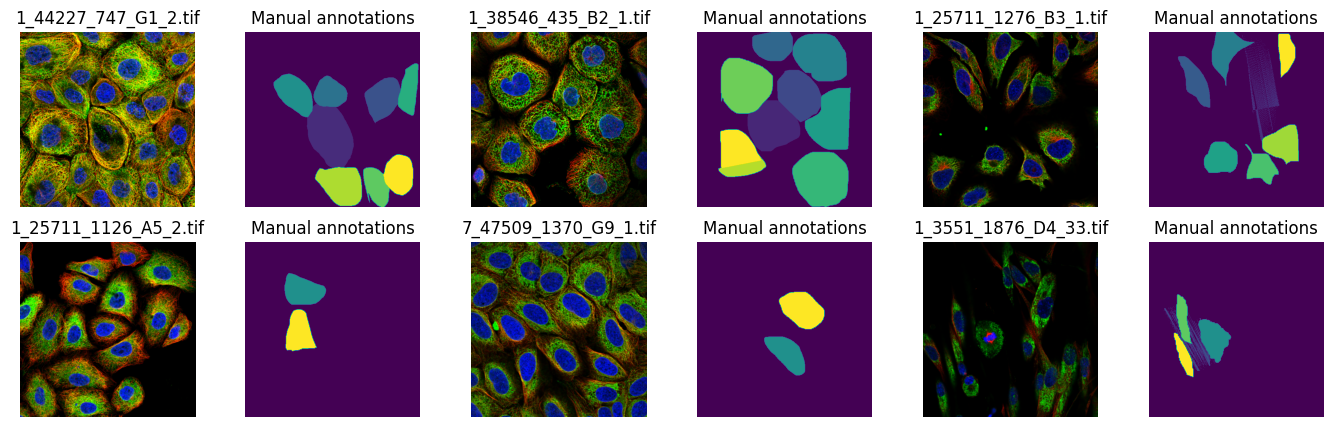

In [7]:
import matplotlib.pyplot as plt

path2label = os.path.join(outpath, "labels")
path2source = os.path.join(outpath, "source")
annotations = [f for f in os.listdir(path2source) if f.endswith(".tif")]

if len(annotations)<6:
    #plot one single annotation starting from k
    k=0
    plt.figure(figsize=(10,20))
    plt.subplot(1,2,1)
    plt.imshow(imread(os.path.join(path2source, annotations[k])))
    plt.title(f"{annotations[k]}")
    plt.subplot(1,2,2)
    plt.imshow(imread(os.path.join(path2label, annotations[k])))
    plt.title(f"Manual annotations")
    plt.show()
else:
    # plot several random annotations
    choices = np.random.choice(len(annotations), 6, replace=False)
    plt.figure(figsize=(17,5))
    for i in range(6):    
        plt.subplot(2,6,2*(i+1)-1)
        plt.imshow(imread(os.path.join(path2source, annotations[choices[i]])))
        plt.axis('off')
        plt.title(f"{annotations[choices[i]]}")
        plt.subplot(2,6,2*(i+1))
        plt.imshow(imread(os.path.join(path2label, annotations[choices[i]])))
        plt.axis('off')
        plt.title(f"Manual annotations")
    plt.show()
